# Important notes and examples of how to use Extended Least Squares

Example created by Wilson Rocha Lacerda Junior

Here we import the NARMAX model, the metric for model evaluation and the methods to generate sample data for tests. Also, we import pandas for specific usage.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.polynomial_basis import PolynomialNarmax
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_miso_data, get_siso_data


## Generating 1 input 1 output sample data  
### The data is generated by simulating the following model:
$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-2} + e_{k}$

If *colored_noise* is set to True:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$

where $x$ is a uniformly distributed random variable and $\nu$ is a gaussian distributed variable with $\mu=0$ and $\sigma$ is defined by the user.

In the next example we will generate a data with 3000 samples with white noise and selecting 90% of the data to train the model. 

In [16]:
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000,
                                                   colored_noise=True,
                                                   sigma=0.2,
                                                   train_percentage=90)

### First we will train a model without the Extended Least Squares Algorithm for comparison purpose.

In [17]:
model = PolynomialNarmax(non_degree=2,
                         order_selection=True,
                         n_info_values=10,
                         extended_least_squares=False,
                         ylag=2, xlag=2,
                         info_criteria='aic',
                         estimator='least_squares',
                         )

In [18]:
model.fit(x_train, y_train)
yhat = model.predict(x_valid, y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

0.4708917315309129


### Clearly we have something wrong with the obtained model. See the *basic_steps* notebook to compare the results obtained using the same data but without colored noise. But let take a look in whats is wrong.

In [19]:
results = pd.DataFrame(model.results(err_precision=8,
                                     dtype='dec'),
                       columns=['Regressors', 'Parameters', 'ERR'])

print(results)

Regressors Parameters         ERR
0        u1(k-2)     0.9076  0.73414977
1         y(k-1)     0.2936  0.08698868
2  u1(k-1)y(k-1)     0.0789  0.00231002


### As we can observe above, the model structure is exact the same the one that generate the data. You can se that the ERR ordered the terms in the correct way. And this is an importante note regarding the Error Reduction Ratio algorithm used here: __it is very robust to colored noise!!__ 

### That is a greate feature! However, although the structure is correct, the model *parameters* are not ok! Here we have a biased estimation! The real parameter for $y_{k-1}$ is $0.2$, not $0.3$.

### In this case, we are actually modeling using a NARX model, not a NARMAX. The MA part exists to allow a unbiased estimation of the parameters. To achieve a unbiased estimation of the parameters we have the Extend Least Squares algorithm. Remember, if the data have only white noise, NARX is fine. 

###  Before applying the Extended Least Squares Algorithm we will run several NARX models to check how different the estimated parameters are from the real ones.

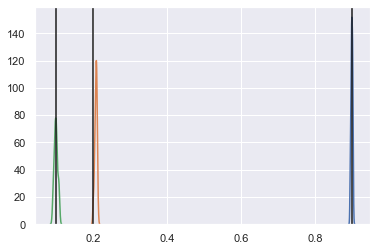

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

parameters = np.zeros([3, 50])

for i in range(50):
    x_train, x_valid, y_train, y_valid = get_siso_data(n=3000,
                                                       colored_noise=True,
                                                       train_percentage=90)
    
    model.fit(x_train, y_train)
    parameters[:, i] = list(model.theta)

sns.set()
pal = sns.cubehelix_palette(3, rot=-.5, dark=.3)

ax = sns.kdeplot(parameters.T[:, 0])
ax = sns.kdeplot(parameters.T[:, 1])
ax = sns.kdeplot(parameters.T[:, 2])
# plotting a vertical line where the real values must lie
ax = plt.axvline(x=0.1, c='k')
ax = plt.axvline(x=0.2, c='k')
ax = plt.axvline(x=0.9, c='k')


### As shown in figure above, we have a problem to estimate the parameter for $y_{k-1}$. Now we will use the Extended Least Squares Algorithm.

### In SysIdentPy, just set *extended_least_squares* to *True* and the algorithm will be applied.

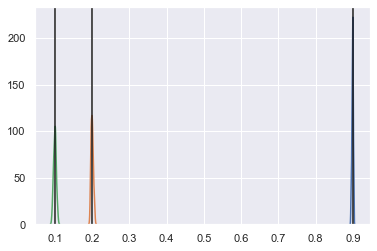

In [21]:
parameters = np.zeros([3, 50])

for i in range(50):
    x_train, x_valid, y_train, y_valid = get_siso_data(n=3000,
                                                       colored_noise=True,
                                                       train_percentage=90)

    model = PolynomialNarmax(non_degree=2,
                             n_terms=3,
                             extended_least_squares=True,
                             ylag=2, xlag=2,
                             estimator='least_squares',
                             )
    
    model.fit(x_train, y_train)
    parameters[:, i] = list(model.theta)

sns.set()
pal = sns.cubehelix_palette(3, rot=-.5, dark=.3)

ax = sns.kdeplot(parameters.T[:, 0])
ax = sns.kdeplot(parameters.T[:, 1])
ax = sns.kdeplot(parameters.T[:, 2])
# plotting a vertical line where the real values must lie
ax = plt.axvline(x=0.1, c='k')
ax = plt.axvline(x=0.2, c='k')
ax = plt.axvline(x=0.9, c='k')

### Great! Now we have an unbiased estimation of the parameters! 

### Note: The Extended Least Squares is an iterative algorithm. In SysIdentpy we fixed 30 iterations because it is knwon from literature that the algorithm converges quickly (about 10 or 20 iterations). Also, we create a specific set of noise regressors for estimation (order 2 and nonlinearity also equal 2). It is suposed to work in most cases, however we will add the possibility to choose the order and nonlinearity degree for noise regressors in future releases.